# Eigenfaces

This guide will go through the classic ['Eigenfaces'](https://en.wikipedia.org/wiki/Eigenface) procedure in computer vision and machine learning. The guide should serve as a good introduction to [dimensionality reduction](https://en.wikipedia.org/wiki/Dimensionality_reduction) and [principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis). Besides for being extremely important for machine learning, dimensionality reduction will give us some insights into the nature of the data distributions, how to model them, and are a first step towards understanding [generative models](https://en.wikipedia.org/wiki/Generative_model) like [autoencoders](https://en.wikipedia.org/wiki/Autoencoder) and [generative adversarial networks](https://arxiv.org/abs/1511.06434).

To go through this guide, you need to install:

 * [scikit-learn](scikit-learn.org)
 * [tqdm](https://pypi.python.org/pypi/tqdm)
 * [Pillow](https://python-pillow.org/)
 * [matplotlib](http://matplotlib.org)

You also need to download and unzip the 'labeled faces in the wild' dataset which can be downloaded from:

 * [http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz](http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz)
 
Run the first cell to verify all the libraries and load all of the images in LFW into memory.

In [2]:
%matplotlib inline

import fnmatch
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tqdm import tqdm
import random
from sklearn.decomposition import PCA

lfw_path = "../data/lfw_funneled"

images = []
for root, dirnames, filenames in os.walk(lfw_path):
    for filename in fnmatch.filter(filenames, '*.jpg'):
        images.append(os.path.join(root, filename))

n = len(images)
print("loaded %d face images" % n)

loaded 13233 face images


Let's have a look at a random selection of faces in LFW.

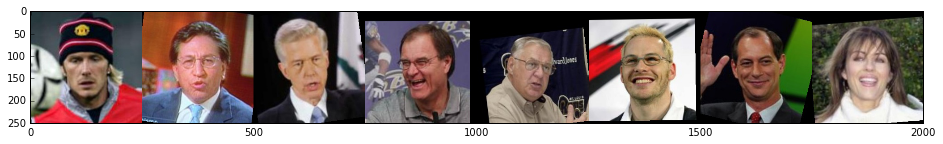

In [3]:
img = [Image.open(images[int(n*random.random())]) for i in range(8)]
img = np.concatenate([np.array(im.getdata()).reshape((im.size[0], im.size[1], 3)) for im in img ], axis=1)
plt.figure(figsize=(16,2))
plt.imshow(Image.fromarray(img.astype('uint8')))

Let's resize all the images to `64*64` and put them into a `n*d` matrix, where the `n` rows correspond to our `n` face images of size `d=64*64=4096`.

In [4]:
w = h = 100

X = np.zeros((n, w*h*3))
for i, img in tqdm(enumerate(images)):
    im = Image.open(img)
    im = im.resize((w, h))#.convert('L')
    pixels = list(im.getdata())
    X[i, :] = np.array(pixels).flatten()

13233it [01:55, 114.75it/s]


Now that we have our data matrix, let's apply principal component analysis to it, and keep the first `n_components = 100` principal components. PCA maps the original points into a smaller subspace by transforming them into a space whose basis vectors are the principal components of the original data which capture the most variance within the data. This gives us a much smaller representation of the original data, but preserves most of the information. 

In [5]:
n_components = 100

pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
  svd_solver='randomized', tol=0.0, whiten=True)

After calculating the principal components, we use them to project the original data points `X` into a `n_components`-dimensional space.

In [6]:
Xp = pca.transform(X)
print(Xp)

[[-1.39376448  1.77431855 -0.23445537 ..., -0.25424124  0.29773056
  -0.31017692]
 [-0.5013077   0.13749541  0.57190141 ...,  0.69170862  0.61377703
  -1.4595762 ]
 [ 0.35573575  0.83974058 -1.15423884 ...,  0.33931792 -0.27321424
  -0.54231417]
 ..., 
 [-0.80020942 -0.51187989 -1.34662922 ..., -0.68070661  0.24930092
   0.80819983]
 [-1.31239152 -0.22458005  0.80998349 ...,  0.24896242 -0.7094856
  -0.82875663]
 [-1.40931463  1.33759458 -0.28731356 ..., -0.1408596  -0.26433751
   0.51296202]]


The rows of `Xp` can be interpreted as compressed representations of the rows of `X`. Two vectors which are similar in `X` (i.e. have a small distance between them) should be similar in `X` as well.

PCA works (usually) using a [singular value decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition) of the data matrix. This is a matrix factorization in which the principal component vectors are ordered by decreasing variance. The dimensionality reduction is achieved simply by removing all but the first `n_components` components. Thus `Xp` is sized `n * num_components`.

Because PCA comes from a matrix factorization, we can simply invert the formula to reproject the new points back into the original pixel space. This gives us a new matrix, `Xt` which is the reconstruction of `X` from the principal components.

In [7]:
Xt = pca.inverse_transform(Xp)

But remember! We have discarded some of the information when we projected the original points into PCA space. Thus the reconstruction is not perfect, it is lossy. How lossy is it?  We can see this by projecting the PCA points of several faces back into pixel space, and comparing their reconstructions against the original images.

The following cell picks a random selection of 8 faces from LFW, and compares the original (resized to 64x64) pixels against the ones reconstructed from the PCA.

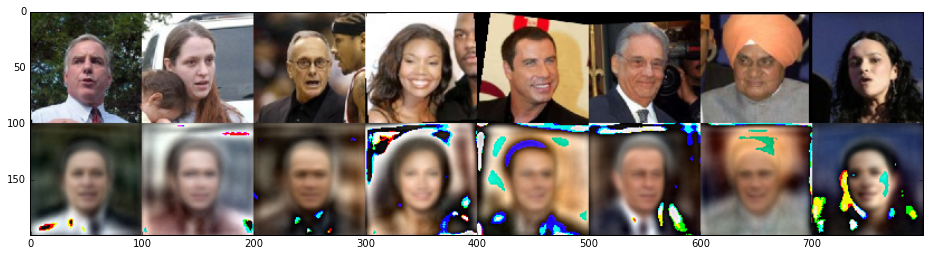

In [8]:
img_pairs = [[X[idx].reshape((w,h,3)), Xt[idx].reshape((w,h,3))] for idx in np.random.randint(n, size=8)]
img_all = np.concatenate([ np.concatenate([p[0], p[1]]) for p in img_pairs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(Image.fromarray(img_all.astype('uint8')))

As you can see the reconstructions give the impression of the originals, but look like they have lost a lot of the  information. Nevertheless, it should seem impressive that we've been able to reconstruct something which resembles the original image, given that the reconstruction came from just a code of 100 numbers. The original images were represented by 64 * 64 * 3 = 12,288 numbers. That's a huge compression!

Here's another idea. What if instead of reprojecting the PCA-projected points from the original data... we just tried to project random numbers back into pixel space! 

The following bit of code will create 8 random codes (equivalent to our points in PCA space) which are centered between -2 and 2 (very roughly the middle region of `Xp`). It will then project those codes into pixel space using our inverted principal component analysis.

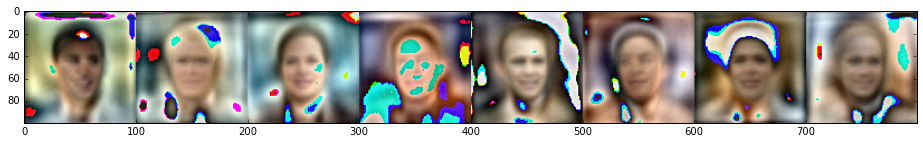

In [33]:
Y = [ -2 + 4*np.random.random((1,n_components)) for i in range(8) ] 
Yt = [ pca.inverse_transform(y) for y in Y ]
Yt = np.concatenate([ yt.reshape((w,h,3)) for yt in Yt ], axis=1)
plt.figure(figsize=(16,2))
plt.imshow(Image.fromarray(Yt.astype('uint8')))

Remarkably, a random vector projected through our PCA vectors creates what appears to be a face! And quite a variety of them! The reconstruction is not perfect -- some parts of it appear burned. And it's quite blurry...  But cool that a little bit of dust can magically create something we recognize.

Here's another technique.  What if we take two random faces from our dataset, and project a series of vectors which are taken by interpolating between the PCA vectors of those two faces? The following cell will generate three series of those (with 8 interpolations in between).

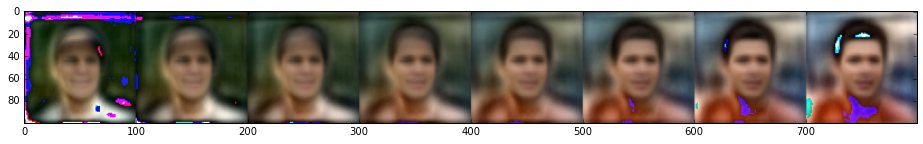

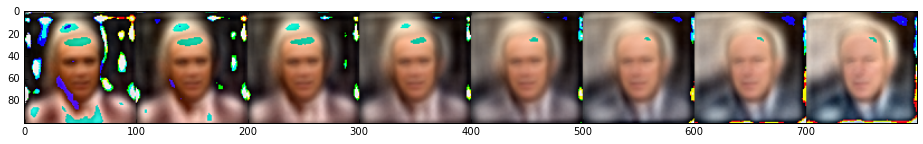

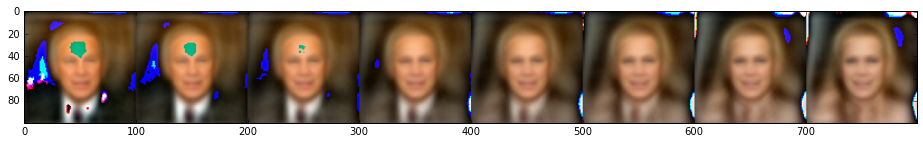

In [12]:
for i in range(3):
    xp1, xp2 = Xp[int(n*random.random())], Xp[int(n*random.random())]
    Z = [[(1.0-r)*i1 + r*i2 for i1, i2 in zip(xp1, xp2)] for r in np.linspace(0,1,8)]
    Y = np.concatenate([ pca.inverse_transform(z).reshape((w,h,3)) for z in Z ], axis=1)
    plt.figure(figsize=(16,2))
    plt.imshow(Image.fromarray(Y.astype('uint8')))

The below code will generate the frames for a movie which has a grid of faces going through interpolations using the technique above. The code is messy but should work.

In [38]:
import scipy.misc
import os

cols, rows = 4, 4
nf = 24  # num frames per transitions
ni = 4   # num transitions

folder='temp'
os.makedirs(folder)
os.makedirs('%s/composite'%folder)
for i in range(cols):
    for j in range(rows):
        idx = np.random.randint(n, size=ni)
        idx = np.append(idx, idx[0])
        f = 1
        for k in range(ni):
            xp1, xp2 = Xp[idx[k]], Xp[idx[k+1]]
            Z = [[(1.0-r)*i1 + r*i2 for i1, i2 in zip(xp1, xp2)] for r in np.linspace(0,1,nf)]
            Y = [ pca.inverse_transform(z).reshape((w,h,3)) for z in Z ]
            for y in Y:
                scipy.misc.imsave('%s/face%02d_%02d_frame%04d.png'%(folder,i,j,f), y.astype('uint8'))
                f+=1
offset = np.random.randint(nf*(ni-1), size=cols*rows)
for f in range(1,nf*ni+1):
    img = Image.new('RGB',(w * cols, h * rows))
    for i in range(cols):
        for j in range(rows):
            fidx = (f + offset[i*rows+j])%(nf*ni)
            im = Image.open('%s/face%02d_%02d_frame%04d.png'%(folder,i,j,f))
            img.paste(im, (i*w, j*h))
    img = img.resize((int(1.2*img.size[0]), int(1.2*img.size[1]))) #upscale just a bit
    scipy.misc.imsave('temp/composite/frame%04d.png'%f, img)